[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/experimental/semantic-search-intro/bm25.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/experimental/semantic-search-intro/bm25.ipynb)

# BM-25

In this notebook we'll work through the BM25 algorithm, let's put together a few sentences that we can use for measuring matches and similarity.

In [1]:
a = "purple is the best city in the forest".split()
b = "there is an art to getting your way and throwing bananas on to the street is not it".split()
c = "it is not often you find soggy bananas on the street".split()
d = "green should have smelled more tranquil but somehow it just tasted rotten".split()
e = "joyce enjoyed eating pancakes with ketchup".split()
f = "as the asteroid hurtled toward earth becky was upset her dentist appointment had been canceled".split()

In [2]:
docs = [a, b, c, d, e, f]

The BM25 algorithm can look intimidating at first, but it's not that different from TF-IDF. Let's start with TF-IDF first.

In [3]:
import numpy as np

def tfidf(word, sentence):
    # term frequency
    tf = sentence.count(word) / len(sentence)
    # inverse document frequency
    idf = np.log10(len(docs) / sum([1 for doc in docs if word in doc]))
    return round(tf*idf, 4)

In [4]:
tfidf('purple', a)  # let's calculate TF-IDF for our query 'purple' and sentence a

0.0973

For BM25, we still calculate both a TF and an IDF component. 

The **TF** component includes the query frequency, and total number of terms as with TF-IDF, but we add two special parameters `k` and `b` which we can use to optimize our algorithm, but by default we stick with the values of `1.2` and `0.75` respectively. We also include two new values - `avgdl`, the average length of *all* documents, and *D*, the length of the current document (`len(sentence)`).

Our new **IDF** component is similar, it maintains the parametes `N` and `N_q`, which are the number of documents and the number of documents *that contain* our query, respectively. And all we do is add a few values (0.5, 1) here and there.

In [5]:
avgdl = sum(len(sentence) for sentence in [a,b,c,d,e,f]) / len(docs)
N = len(docs)

def bm25(word, sentence, k=1.2, b=0.75):
    # term frequency...
    freq = sentence.count(word)  # or f(q,D) - freq of query in Doc
    tf = (freq * (k + 1)) / (freq + k * (1 - b + b * len(sentence) / avgdl))
    # inverse document frequency...
    N_q = sum([1 for doc in docs if word in doc])  # number of docs that contain the word
    idf = np.log(((N - N_q + 0.5) / (N_q + 0.5)) + 1)
    return round(tf*idf, 4)

Let's run a few tests.

In [6]:
bm25('purple', a)

1.7677

In [7]:
bm25('purple', b)

0.0

In [8]:
bm25('bananas', b)

0.8425

In [9]:
bm25('bananas', c)

1.0543

In [10]:
tfidf('bananas', b)

0.0265

In [11]:
tfidf('bananas', c)

0.0434

---

## BM25 Vectors

We can put together sparse vector representations of each sentence using BM25 like so:

In [12]:
vocab = set(a+b+c+d+e+f)
print(vocab)

{'somehow', 'to', 'smelled', 'is', 'more', 'dentist', 'eating', 'appointment', 'as', 'bananas', 'best', 'there', 'way', 'you', 'throwing', 'her', 'hurtled', 'getting', 'canceled', 'upset', 'asteroid', 'find', 'not', 'forest', 'green', 'tasted', 'but', 'street', 'had', 'ketchup', 'have', 'pancakes', 'should', 'just', 'purple', 'soggy', 'becky', 'tranquil', 'rotten', 'joyce', 'was', 'on', 'enjoyed', 'the', 'toward', 'city', 'earth', 'your', 'been', 'and', 'an', 'often', 'in', 'with', 'it', 'art'}


In [13]:
vec = []
# we will create the BM25 vector for sentence 'a'
for word in vocab:
    vec.append(bm25(word, a))
print(vec)

[0.0, 0.0, 0.0, 0.7954, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7677, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7677, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7677, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6664, 0.0, 1.7677, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7677, 0.0, 0.0, 0.0]


---

## Visualizing BM25 and TF-IDF

So that's how BM25 works, now let's take a visualize the scoring of both *TF-IDF* and *BM25* with a different number of matching terms.

In [14]:
def tfidf_viz(w, s, n_t):
    tf = w / s
    idf = np.log10(len(docs) / n_t)
    return tf, idf

def bm25_viz(w, s, N_t, k=1.2, b=0.75):
    tf = (w * (k + 1)) / (w + k * (1 - b + b * (s / avgdl)))
    idf = np.log10(((N - N_t + 0.5) / (N_t + 0.5)) + 1)
    return tf, idf

We'll run through our functions and output scores for term frequencies from *1* upto *11**.

In [15]:
tfidf_scores = []
bm25_scores = []

for i in range(12):
    tfidf_scores.append(tfidf_viz(i, avgdl, 2))
    bm25_scores.append(bm25_viz(i, avgdl, 2))

In [16]:
import matplotlib.pyplot as plt

We'll visualize TF and IDF seperately first.

In [17]:
tfidf_tf = [x[0] for x in tfidf_scores]
tfidf_idf = [x[1] for x in tfidf_scores]

bm25_tf = [x[0] for x in bm25_scores]
bm25_idf = [x[1] for x in bm25_scores]

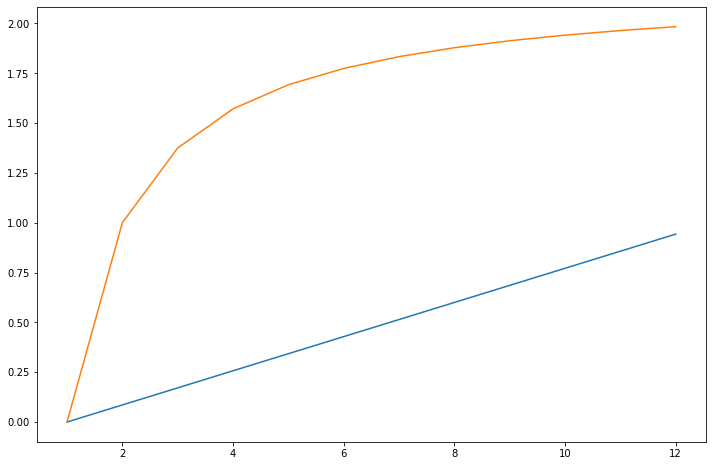

In [18]:
plt.figure(figsize=(12, 8))

plt.plot(list(range(1, len(tfidf_tf)+1)), tfidf_tf)
plt.plot(list(range(1, len(bm25_tf)+1)), bm25_tf)

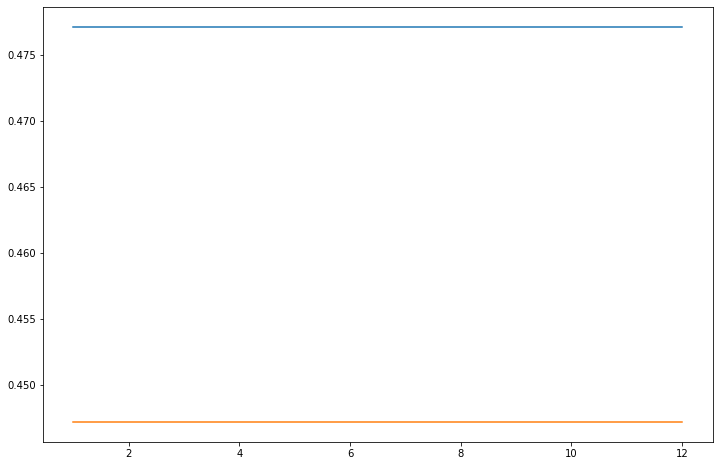

In [19]:
plt.figure(figsize=(12, 8))

plt.plot(list(range(1, len(tfidf_idf)+1)), tfidf_idf)
plt.plot(list(range(1, len(bm25_idf)+1)), bm25_idf)

In [20]:
# calculate full tf*idf
tfidf_tfidf = [tf*idf for tf, idf in zip(tfidf_tf, tfidf_idf)]
bm25_tfidf = [tf*idf for tf, idf in zip(bm25_tf, bm25_idf)]

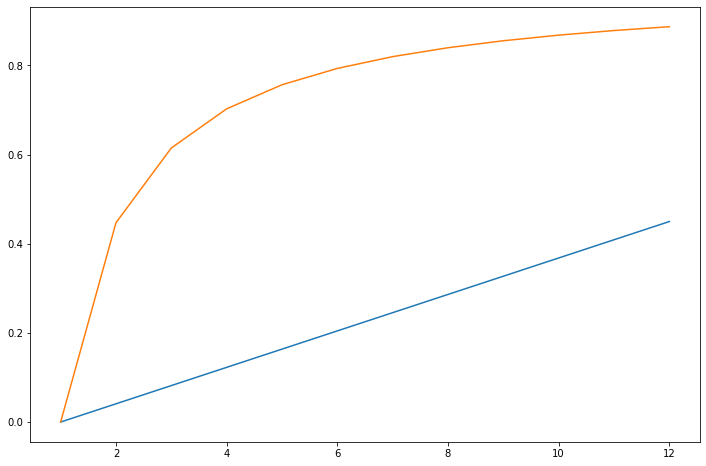

In [21]:
plt.figure(figsize=(12, 8))

plt.plot(list(range(1, len(tfidf_tfidf)+1)), tfidf_tfidf)
plt.plot(list(range(1, len(bm25_tfidf)+1)), bm25_tfidf)

In our ~12 token sentence, doubling the number of relevant tokens from 2 to 4 doubles the TF*IDF score, but for BM25 it increases by a factor of 1.25. Going further, while the TF*IDF score doubles with every doubling of relevant tokens, the scaling factor of BM25 decreases. From 4 to 8 tokens the factors are x2 and x1.13 respectively.

| # of relevant tokens | TF*IDF | BM25 |
| --- | --- | --- |
| 1 | 0.04 | 0.45 |
| 2 | 0.08 | 0.61 |
| 4 | 0.16 | 0.76 |
| 8 | 0.33 | 0.86 |

(0.0, 0.47235004217246584)

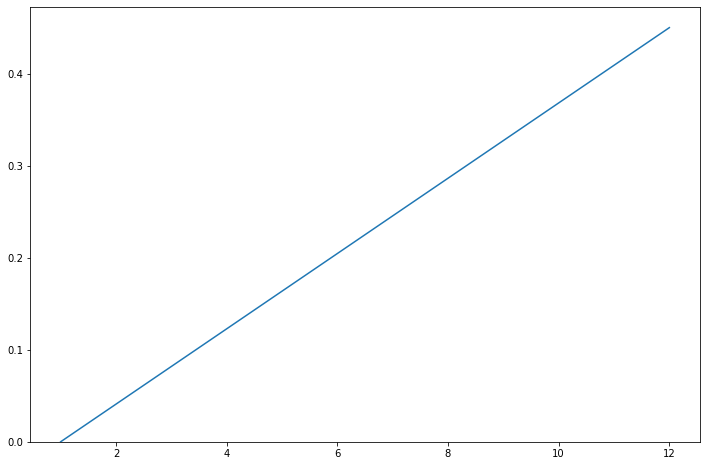

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, len(tfidf_tfidf)+1)), tfidf_tfidf)
plt.ylim(0, plt.ylim()[-1])

(0.0, 0.9313348833119501)

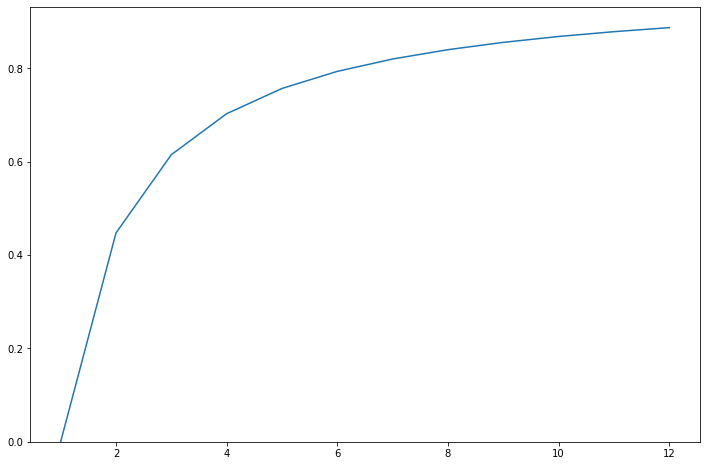

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, len(bm25_tfidf)+1)), bm25_tfidf)
plt.ylim(0, plt.ylim()[-1])